In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA


In [20]:
from pathlib import Path

# Use absolute path to workspace data file to avoid kernel working-dir issues
data_path = Path(r"D:/RAMAR TECH/FUTURE_ML_01/data/sales.csv")
print("Reading data from:", data_path)
df = pd.read_csv(data_path, encoding="latin1")
df.head()


Reading data from: D:\RAMAR TECH\FUTURE_ML_01\data\sales.csv


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [12]:
print("Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())


Shape: (9994, 21)

Missing Values:
 Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64

Duplicate Rows: 0


In [14]:
df = df.drop_duplicates()
print("After removing duplicates:", df.shape)


After removing duplicates: (9994, 21)


In [16]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')
df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce')
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')


In [18]:
df = df.dropna(subset=['Order Date', 'Sales'])
print("After dropping missing Order Date & Sales:", df.shape)


After dropping missing Order Date & Sales: (9994, 21)


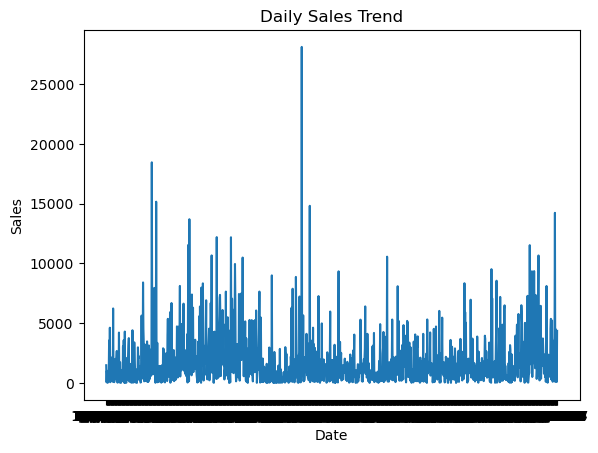

In [21]:
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()

plt.figure()
plt.plot(daily_sales['Order Date'], daily_sales['Sales'])
plt.title("Daily Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()


In [27]:
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')

print(df['Order Date'].dtype)


datetime64[ns]


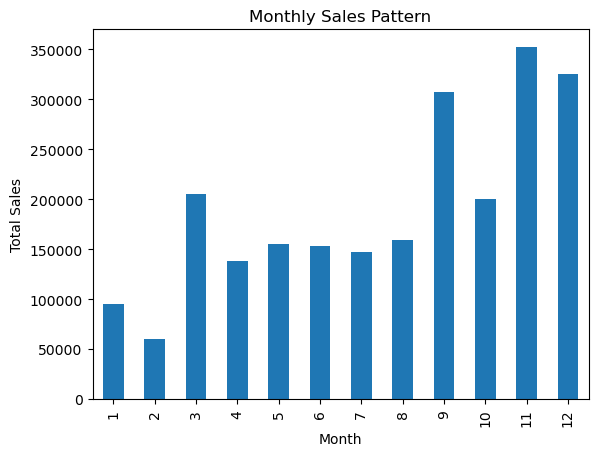

In [29]:
df['Month'] = df['Order Date'].dt.month

monthly_sales = df.groupby('Month')['Sales'].sum()

plt.figure()
monthly_sales.plot(kind='bar')
plt.title("Monthly Sales Pattern")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.show()


In [50]:
# Aggregate daily sales again (safe)
daily_sales = df.groupby('Order Date')['Sales'].sum().reset_index()

# Set date as index
ts_data = daily_sales.set_index('Order Date')['Sales']

ts_data.head()


Order Date
2014-01-03      16.448
2014-01-04     288.060
2014-01-05      19.536
2014-01-06    4407.100
2014-01-07      87.158
Name: Sales, dtype: float64

In [33]:
train_size = int(len(ts_data) * 0.8)
train, test = ts_data[:train_size], ts_data[train_size:]

print("Train size:", train.shape)
print("Test size:", test.shape)


Train size: (989,)
Test size: (248,)


In [35]:
daily_sales['Year'] = daily_sales['Order Date'].dt.year
daily_sales['Month'] = daily_sales['Order Date'].dt.month
daily_sales['Day'] = daily_sales['Order Date'].dt.day
daily_sales['DayOfWeek'] = daily_sales['Order Date'].dt.dayofweek

X = daily_sales[['Year','Month','Day','DayOfWeek']]
y = daily_sales['Sales']

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


In [36]:
rf_model = RandomForestRegressor(n_estimators=150, random_state=42)
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)

print("RF MAE:", mean_absolute_error(y_test, rf_pred))
print("RF RMSE:", np.sqrt(mean_squared_error(y_test, rf_pred)))


RF MAE: 1810.3017561182796
RF RMSE: 2554.541635321852


In [38]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train, order=(5,1,0))
arima_fit = arima_model.fit()

arima_pred = arima_fit.forecast(steps=len(test))

print("ARIMA MAE:", mean_absolute_error(test, arima_pred))
print("ARIMA RMSE:", np.sqrt(mean_squared_error(test, arima_pred)))


ARIMA MAE: 1758.223714877261
ARIMA RMSE: 2495.74836568978


c:\Users\RAMAN K\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\RAMAN K\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\RAMAN K\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\RAMAN K\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_ind

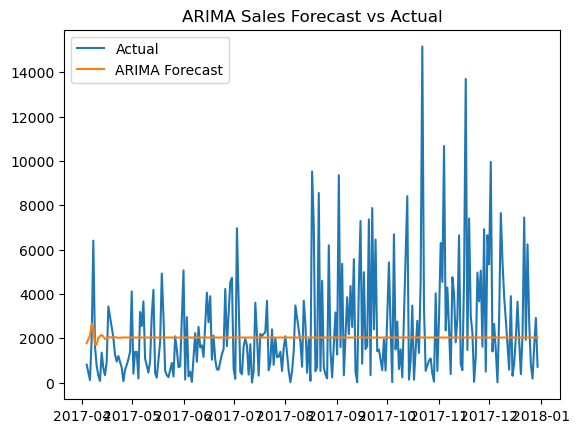

In [40]:
plt.figure()
plt.plot(test.index, test.values, label="Actual")
plt.plot(test.index, arima_pred, label="ARIMA Forecast")
plt.legend()
plt.title("ARIMA Sales Forecast vs Actual")
plt.show()


c:\Users\RAMAN K\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


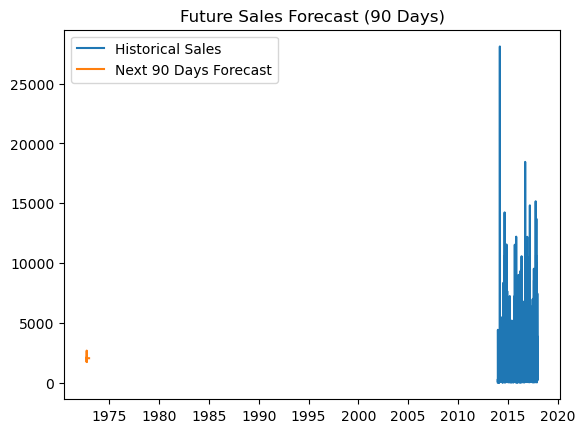

In [42]:
future_90 = arima_fit.forecast(steps=90)

plt.figure()
plt.plot(ts_data, label="Historical Sales")
plt.plot(future_90, label="Next 90 Days Forecast")
plt.legend()
plt.title("Future Sales Forecast (90 Days)")
plt.show()


In [44]:
results = pd.DataFrame({
    "Model": ["Random Forest", "ARIMA"],
    "MAE": [
        mean_absolute_error(y_test, rf_pred),
        mean_absolute_error(test, arima_pred)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(y_test, rf_pred)),
        np.sqrt(mean_squared_error(test, arima_pred))
    ]
})

results


,Model,MAE,RMSE
0,Random Forest,1810.301756,2554.541635
1,ARIMA,1758.223715,2495.748366


In [51]:
future_df = pd.DataFrame({
    "Date": future_90.index,
    "Forecasted_Sales": future_90.values
})

future_df.to_csv("../report/future_90_days_forecast.csv", index=False)

future_df.head()


,Date,Forecasted_Sales
0,989,1774.122472
1,990,2119.258053
2,991,2666.635156
3,992,2506.937962
4,993,1718.535338


In [53]:
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')


In [55]:
df['Month'] = df['Order Date'].dt.month


In [57]:
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='M'))['Sales'].sum()
monthly_sales = monthly_sales.dropna()
monthly_sales.head()


C:\Users\RAMAN K\AppData\Local\Temp\ipykernel_12548\2209071113.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='M'))['Sales'].sum()


Order Date
2014-01-31    14236.895
2014-02-28     4519.892
2014-03-31    55691.009
2014-04-30    28295.345
2014-05-31    23648.287
Freq: ME, Name: Sales, dtype: float64

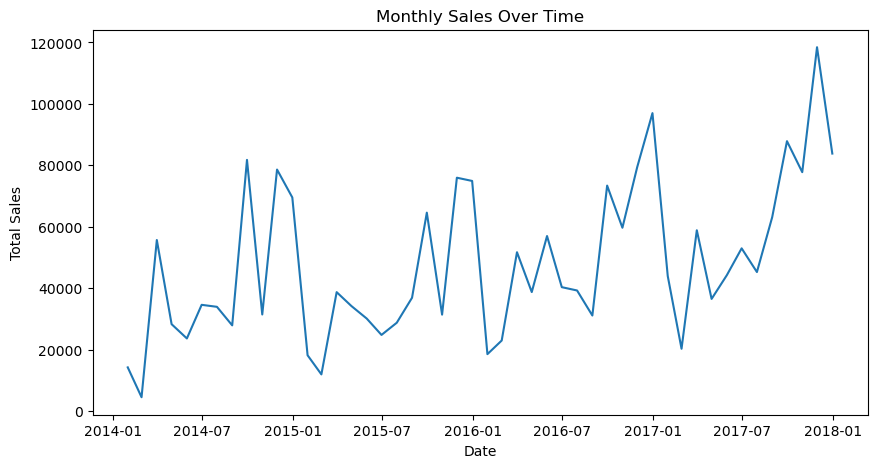

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(monthly_sales)
plt.title("Monthly Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()
